# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

# <font color=red>deepBreaks: Analyzing T1 Opsin Data</font>


In [ ]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import numpy as np
import csv
import pandas as pd
import warnings
import datetime
import os
import shutil
import time

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [ ]:
predictions_list = []

# defining user params, file pathes, analysis type

# path to sequences
seqFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/t1_opsin_fmt.fasta"

# path to metadata
metaDataFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/t1_opsin_metadata.tsv"

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.6

print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
metaFile = metaDataFileName.split('/')[1]
# importing sequences data
print('reading fasta file')
ref_df = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
#merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
ref_df= ref_df.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
#tr.shape

test_iter = 0
first_run = 0
umd = []


In [ ]:
full_df = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
#merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
full_df= full_df.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
full_df.drop(mt, axis=1, inplace=True)

In [ ]:
while ref_df.shape[0]>0:
    tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
    #merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
    tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
    #tr.shape
    # making a unique directory for saving the reports of the analysis
    print('direcory preparation')
    dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    seqFile = seqFileName.split('/')[2]
    print(seqFile)
    seqFile = seqFile.split('.')[0]
    print(seqFile)
    report_dir = str(seqFile +'_' + mt + '_' + dt_label)
    os.makedirs(report_dir)

    #creating a copy of the input fasta file and metadata file into the report directory
    shutil.copy2(f'{seqFileName}' , report_dir)
    shutil.copy2(f'{metaDataFileName}' , report_dir)

    #changing the number of test sequences to extract from the training dataframe based on the size of the training dataset
    if tr.shape[0] <= 150:
        sample_n = 15
    elif tr.shape[0] > 150 and tr.shape[0] <= 300:
        sample_n = 25
    elif tr.shape[0] > 300 and tr.shape[0] <= 1000:
        sample_n = 50
    else:
        sample_n = 100

    n=0
    while n<1:
        try:
            drop_indices = np.random.choice(ref_df.index, sample_n, replace=False)
            #print(drop_indices)
            ref_df = ref_df.drop(drop_indices)
            n+=1
        except:
            sample_n = ref_df.shape[0]

    #copying the sampled indices into a seperate dataframe to act as our 'unseen' test data later
    unseen = tr.loc[drop_indices].copy()
    umd.extend(unseen.loc[:, mt].values)
    #dropping our sample indices from the training dataframe
    unseen.drop(mt, axis=1, inplace=True)
    tr = tr.drop(drop_indices)

    if first_run == 0:
        base_test = meta_data.loc[drop_indices].copy()
        first_run+=1
    else:
        # Use the loc method to add the new row to the DataFrame
        base_test = base_test.append(meta_data.loc[drop_indices].copy())
        print(len(base_test))

    y = tr.loc[:, mt].values
    tr.drop(mt, axis=1, inplace=True)

    #settingthe paramaters for our ML pipeline
    prep_pipeline = make_pipeline(
        steps=[
            ('mc', MisCare(missing_threshold=0.05)),
            ('cc', ConstantCare()),
            ('ur', URareCare(threshold=0.025)),
            ('cc2', ConstantCare()),
            ('one_hot', CustomOneHotEncoder()),
            ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
            ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.05, keep=False))
        ])

    #training models
    report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                                models_dict=get_models(ana_type=ana_type),
                                scoring=get_scores(ana_type=ana_type),
                                report_dir=report_dir,
                                cv=12, ana_type=ana_type, cache_dir=report_dir)

                                
    time.sleep(1)
    #setting parameters for tuning the top 3 performing models
    prep_pipeline = make_pipeline(
        steps=[
            ('mc', MisCare(missing_threshold=0.05)),
            ('cc', ConstantCare()),
            ('ur', URareCare(threshold=0.025)),
            ('cc2', ConstantCare()),
            ('one_hot', CustomOneHotEncoder()),
            ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
            ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.05, keep=True))
        ])

    modified_top = []
    mtml = []
    for model in top:
        modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
        my_top_models = str(model[1:])
        #print(my_top_models)
        my_top_models = my_top_models.split("'")[3]
        mtml.append(my_top_models)
        #print(my_top_models)

    #print(mtml)
    time.sleep(1)

    #tuning the top 3 performing models 
    top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_params(),report_dir=report_dir, cv=10)
    #summarize the results by extracting feature importance and p-values and grouping correlated features.
    sr = summarize_results(top_models=top, report_dir=report_dir)
    #plot a scatter plot with -log of (p-value) column as the x-axis and the values of the other columns 
    scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

    time.sleep(1)

    #plot mean relative importance of each feature - corresponding to an amino acid position.
    mean_imp = mean_importance(top, report_dir=report_dir)

    dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)
    tr = prep_pipeline[:4].fit_transform(tr)

    for model in top:
        model_name = model.steps[-1][0]
        dp_plot(importance=importance_from_pipe(model),
                imp_col='standard_value',
                model_name = model_name, report_dir=report_dir)
        
        plot_imp_model(importance=importance_from_pipe(model), 
                X_train=tr, y_train=y, model_name=model_name,
                    meta_var='meta', model_type=ana_type, report_dir=report_dir)

    time.sleep(1)
                    

    from deepBreaks.utils import load_obj
    import joblib
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.metrics import mean_squared_error

    plt.show()
    plt.clf()

    #load and test the top performing linear regression model.
    top_per_mod = report_dir + '/' + mtml[0] + '.pkl'
    load_rf = load_obj(top_per_mod)
    time.sleep(3)
    predictions = load_rf.predict(unseen)
    predictions_list.extend(predictions)
    #print(predictions)
   
    #cycling to next set of data split files.
    #opsin_data_count+=1


In [ ]:
predictions_list2 = []
for pred in predictions_list:
    p = float(pred)
    predictions_list2.append(p)
umd2 = []
for lmax in umd:
    p = float(lmax)
    umd2.append(p)


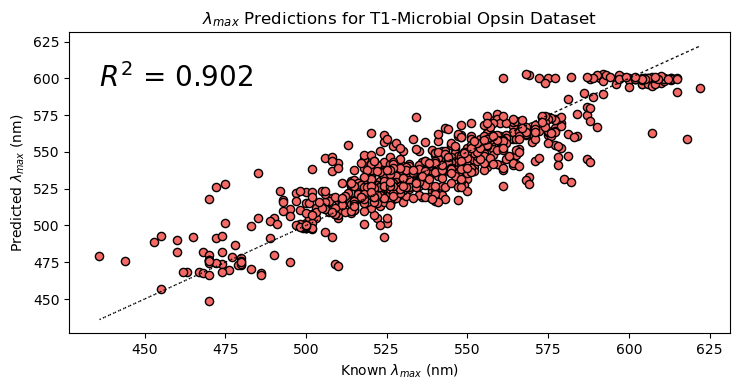

0.9017884625791933


<Figure size 750x400 with 0 Axes>

In [10]:
#adding in the predicted lamda max into the test df
base_test['Prediction'] = predictions_list
#adding the difference between predicted and known lambda max into df
base_test['Difference'] = base_test['Prediction'] - base_test['Lambda_Max']
#writing df to a csv file for secondary analysis in report directory
base_test.to_csv(path_or_buf= f'{report_dir}/basetest_results.csv',index = 'Feature',mode="w")

#plotting the predicted vs. known lambda max values
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
plt.title("$λ_{max}$ Predictions for T1-Microbial Opsin Dataset")
plt.scatter(umd, predictions_list, c='#F56A66', ec = 'k', edgecolors='k', s = 35)
plt.plot(umd, umd, c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

plt.annotate(f"$R^2$ = {stats.linregress(umd2,predictions_list2)[2]:.3f}",(min(umd), (max(umd) - ((max(umd) - min(umd)) *  0.15))), fontsize = 20, c = 'k')
#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{report_dir}/t1_whole.pdf'
plt.savefig(fileout)
plt.show()
plt.clf()

time.sleep(1)

#calculating r^2, mae, mape, sqe, and rsque for the model on our subsample of extracted test data
model_testing__report = f'{report_dir}/model_testing report.tsv'
base_rsq = stats.linregress(umd2,predictions_list2)[2]
print(base_rsq)
base_mae = mean_absolute_error(predictions_list,umd)
#print(base_mae)
base_mape = mean_absolute_percentage_error(predictions_list,umd)
#print(base_mape)
base_sqe = mean_squared_error(predictions_list,umd)
#print(base_sqe)
base_rsqe = mean_squared_error(predictions_list,umd, squared = False)
#print(base_rsqe)
with open(model_testing__report , 'a') as f:
    f.write(f'Base Model R^2\tMAE\tMAPE\tSQE\tRSQE\n')
    f.write(f'{str(base_rsq)}\t{str(base_mae)}\t{str(base_mape)}\t{str(base_sqe)}\t{str(base_rsqe)}')

In [3]:
from scipy import stats
import re
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from deepBreaks.preprocessing import read_data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [4]:
directory = './results_4_paper/full_iter_sample_tests/'
metaDataFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/t1_meta.tsv"
testFileName = f"{directory}t1_test_results.csv"
data_set = 'T1'

base_test = read_data(testFileName, seq_type = None, is_main=False)


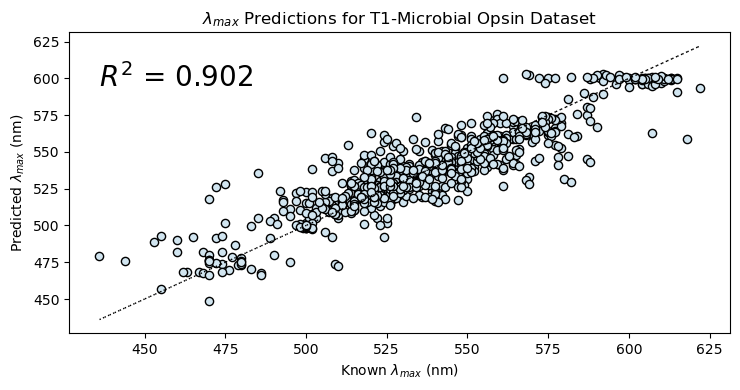

<Figure size 750x400 with 0 Axes>

In [5]:
#MAKE THIS A FUCNTION!?!?!? vvv
#plotting the predicted vs. known lambda max values
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
plt.title("$λ_{max}$ Predictions for T1-Microbial Opsin Dataset")
plt.scatter(base_test['Lambda_Max'], base_test['Prediction'], c='#d1e5f0', ec = 'k', edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]:.3f}",(min(base_test['Lambda_Max']), (max(base_test['Lambda_Max']) - ((max(base_test['Lambda_Max']) - min(base_test['Lambda_Max'])) *  0.15))), fontsize = 20, c = 'k')

#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{directory}{data_set}_full_test.png'
plt.savefig(fileout)
fileout = f'{directory}{data_set}_full_test.pdf'
plt.savefig(fileout)
plt.show()
plt.clf()